# AP(P)3RO PROJECT #

### Projet de deneigement intelligent de Montréal, Canada ###

#### M. Le Gras, A. Naullet, A. Calixte, P. Beaunieux ####

In [2]:
import multiprocessing as mp

import numpy as np
import osmnx as ox
from copy import copy

## Partie 1: Cartographie de la ville par le drone ##

In [107]:
place = "le Perrier, France" # /!\ Replace with Montreal
G = ox.graph_from_place(place, network_type="walk")
#Gp = ox.project_graph(G)


In [154]:
#... blablabla spliter le graph en sous graphs bah c'est nice
#G1
#G2
#G...
G2 = ox.truncate.truncate_graph_dist(G,list(G.nodes)[0],max_dist=2000)
G3 = ox.truncate.truncate_graph_dist(G,list(G.nodes)[-1],max_dist=2000)
GRAPHS_LIST = [G2, G3]

### 1.1: Importation des plans de la ville ###

Whole City:


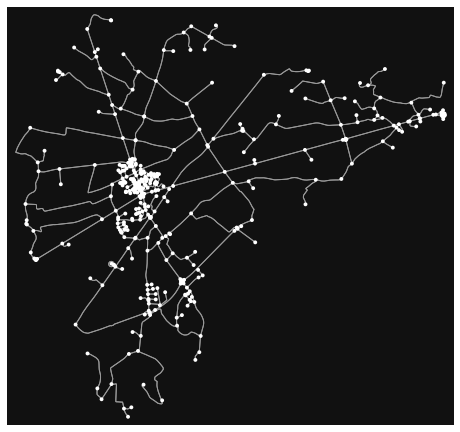

Sub part of city n°1


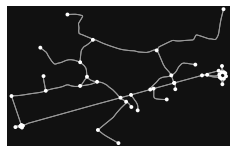

Sub part of city n°2


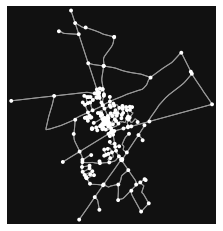

In [177]:
print("Whole City:")
ox.plot_graph(G)
for i, GG in enumerate(GRAPHS_LIST):
    print("Sub part of city n°%d" % (i + 1))
    ox.plot_graph(GG, figsize=(4,4))

In [134]:
### Construction d'une liste de noeud qui a notre format
def to_graph_city(GG):
    node_list = list(GG.edges(data=True))
    graph_city = []
    for node in node_list:
        n1 = node[0]
        n2 = node[1]
        dist = node[2]["length"]
        graph_city.append((n1,n2,dist))
    return graph_city
### On ne pgraph_cityeut pas utiliser l'id des noeuds pour utiliser nos algos.
### On doit construire une table de correspondance entre l'id des noeuds et des numéros croissants de noeuds

CORRESPONDENCE_TABLE = {}
CORRESPONDENCE_TABLE_PRIME = {}

def get_true_node(soft_id):
    if soft_id in CORRESPONDENCE_TABLE_PRIME:
        return CORRESPONDENCE_TABLE_PRIME[soft_id]
    return -1

def to_soft_id_graph(graph_city):
    global CORRESPONDENCE_TABLE_PRIME
    global CORRESPONDENCE_TABLE
    
    CORRESPONDENCE_TABLE_PRIME = {}
    CORRESPONDENCE_TABLE = {}
    
    graph_city_soft_id = []
    soft_id = 1
    
    len_g = len(graph_city)
    index = 1
    
    old_percentage = -1
    for (node1,node2,dist) in graph_city:
        #percentage = (index*100)//len_g
        #print("to soft_id: ",percentage, "%")
        #old_percentage = percentage
        if node1 not in  CORRESPONDENCE_TABLE:
            CORRESPONDENCE_TABLE[node1] = soft_id
            CORRESPONDENCE_TABLE_PRIME[soft_id] = node1
            soft_id += 1
            
        if node2 not in  CORRESPONDENCE_TABLE:
            CORRESPONDENCE_TABLE[node2] = soft_id
            CORRESPONDENCE_TABLE_PRIME[soft_id] = node2
            
            soft_id += 1
        s_id1 = CORRESPONDENCE_TABLE[node1]
        s_id2 = CORRESPONDENCE_TABLE[node2]
        graph_city_soft_id.append((s_id1,s_id2, dist))
    return graph_city_soft_id

def to_real_id_graph(graph_city_soft_id):
    graph_city = []
    soft_id = 1
    for (node1,node2,dist) in graph_city_soft_id:
        n_id1 = get_true_node(node1)
        n_id2 = get_true_node(node2)
    
        graph_city.append((n_id1,n_id2, dist))
    return graph_city

def to_real_id_path(path_soft_id):
    path = []
    soft_id = 1
    for (node1,node2) in path_soft_id:
        n_id1 = get_true_node(node1)
        n_id2 = get_true_node(node2)
    
        path.append(n_id1)
    return path

In [173]:
import scripts.eulerian_transform as eulerian
import importlib
out = importlib.reload(eulerian)

In [180]:
PREDEF_COLORS = ["red", "yellow", "green", "cyan", "purple", "blue","pink", "brown", "magenta", "white", "orange"] #TODO: ADD MORE

ROUTES = []
COLORS = []
for i, GG in enumerate(GRAPHS_LIST):
    print("\n[!] Dealing with sub part of city n°%d" % (i + 1))
    COLORS.append(PREDEF_COLORS[i])
    
    graph_city_2 = to_graph_city(GG)
    graph_city_soft_id_2 = to_soft_id_graph(graph_city_2)
    graph_city_2_prime = to_real_id_graph(graph_city_soft_id_2)
    print("[*] Conversion, re-conversion des graphs: ", ("Erreur","OK")[graph_city_2 == graph_city_2_prime])

    path2 = eulerian.transform_and_find_eulerian_path(graph_city_soft_id_2)
    path_real_id_2 = to_real_id_path(path2)
    ROUTES.append(path_real_id_2)


[!] Dealing with sub part of city n°1
[*] Conversion, re-conversion des graphs:  OK
[*] fixing the Graph
[+] Graph fixed
[*] Graph to dict
[*] Starting Fleury
[*] Compute Eulerian path: 100 %
[+] Euleriand Path Found !

[!] Dealing with sub part of city n°2
[*] Conversion, re-conversion des graphs:  OK
[*] fixing the Graph
[+] Graph fixed
[*] Graph to dict
[*] Starting Fleury
[*] Compute Eulerian path: 100 %
[+] Euleriand Path Found !


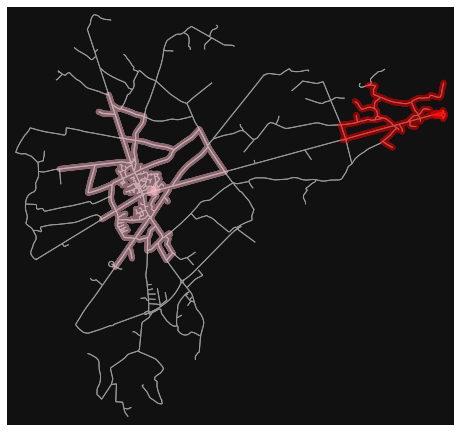

In [181]:

fig, ax = ox.plot_graph_routes(G, ROUTES, route_colors=COLORS, route_linewidth=6, node_size=0)

### 1.2 Calcul du parcours le plus efficace pour le drone ###

In [ ]:
#ICI on fait l'algo

In [ ]:
# ICI ON AFFICHE
#fig, ax = ox.plot_graph_route(G, route, route_linewidth=6, node_size=0, bgcolor='k') --> afficher le parcours avec une liste noeud

### 1.3 Recuperation des données du drones (simulation d'eneigement) ###